### Model Development ###

Up to this point our efforts have been focused on the selection of training pairs or correspondences. These pairs consist of locations of pixels that are in the shade, and associated pixel lists that *may* be the same surface type, but are out in the open. Using the spectral information of the pixels in the open, we develop a model aimed at learning the local radiance attenuation.

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
from hyperspectral import *
import pandas as pd
import numpy as np
import pickle

correspondences = pickle.load(open('data/training_correspondences.p', 'rb'))
hsi_import = np.load('data/hsi_data.npz')
hsi_data = hsi_import['hyperspectral_data']
wavelengths = hsi_import['wavelengths']

lidar_import = np.load('data/lidar_data.npz')
intensity = lidar_import['intensity']
skyview = lidar_import['skyview']

0.0


#### Compiling Observations and Targets ####

Given the correspondences determined in previous steps, we can build the data sets we wish to use in training our models. From the correspondence pairs we have our observations, the pixels in the shade, and a batch of candidate targets, pixels to believed to represent the same material in direct sunlight.  

As the 'candidate' pixels in the open are subject to a degree of variation, we'll run our initial tests using the pixels with the minimum norm, median norm,  and maximum norm. Subsequent model assessments can be utilized to determine which is best going forward.

In [13]:
hsi_data_matrix = multispectral_raster_to_matrix(hsi_data)
image_width = hsi_data.shape[1]

observation_indices = []
min_target_indices = []
med_target_indices = []
max_target_indices = []

for pixel in correspondences:

    observation_indices.append(pixel[0] * image_width + pixel[1])
    
    # compute spectra norms for all corresponding pixels; select the min, median, and max
    open_norms = [ np.linalg.norm(get_spectrum(hsi_data, px)) for px in correspondences[pixel] ]
    norm_indices = np.argsort(open_norms)
    min_norm_pixel = correspondences[pixel][norm_indices[0]]
    med_norm_pixel = correspondences[pixel][norm_indices[len(norm_indices)//2]]
    max_norm_pixel = correspondences[pixel][norm_indices[-1]]
    
    min_target_indices.append(min_norm_pixel[0] * image_width + min_norm_pixel[1])
    med_target_indices.append(med_norm_pixel[0] * image_width + med_norm_pixel[1])
    max_target_indices.append(max_norm_pixel[0] * image_width + max_norm_pixel[1])

observation_matrix = hsi_data_matrix[observation_indices, :]
target_matrices = { 'min' : hsi_data_matrix[min_target_indices, :], 
                   'median' : hsi_data_matrix[med_target_indices, :],
                   'max' : hsi_data_matrix[max_target_indices, :] }

#### Model 01. Reduced Space Ridge Regression ####

As an initial example we evaluate the output of a kernel ridge regression model trained on a reduced dimensionality version of our data. Kernel ridge regression supports multidimensional targets making its use on data such as this immediately accessible.

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from pca import principal_components

number_dimensions = 24

pc = principal_components(hsi_data_matrix)
reduced_observation_matrix = pc.reduce_dimension(observation_matrix, number_dimensions)
reduced_target_matrices = {}
for label in target_matrices:
    reduced_target_matrices[label] = pc.reduce_dimension(target_matrices[label], number_dimensions)

In [20]:
parameters = { 'alpha': [ 0.1, 0.05, 0.01, 0.005 ], 'gamma': [ 1.0, 5.0, 10.0, 50.0  ], 'kernel' : ['linear', 'rbf'] }
model = GridSearchCV(KernelRidge(), parameters, scoring='neg_mean_squared_error', cv=10)

best_model_params = {}

for label in reduced_target_matrices:
    model.fit(reduced_observation_matrix, reduced_target_matrices[label])
    best_model_params[label] = model.best_params_
    print('\nEvaluating model using', label, 'candidate spectra...')
    print('CV RMSE: {:.3f}'.format(-model.best_score_))
    print('CV Selected Parameters:', model.best_params_)


Evaluating model using min candidate spectra...
CV RMSE: 0.009
CV Selected Parameters: {'alpha': 0.05, 'gamma': 5.0, 'kernel': 'rbf'}

Evaluating model using median candidate spectra...
CV RMSE: 0.010
CV Selected Parameters: {'alpha': 0.05, 'gamma': 5.0, 'kernel': 'rbf'}

Evaluating model using max candidate spectra...
CV RMSE: 0.018
CV Selected Parameters: {'alpha': 0.1, 'gamma': 10.0, 'kernel': 'rbf'}


#### Ridge Regression Output Plots ####

In experiments thus far kernel ridge regression has performed best using the minimum corresponding spectra. As a quick visual example we plot the spectra of several observations in the shade against their minimum-norm correspondence, as well as what the model trained on minimum-norm correspondences estimates the unobstructed radiance should be.

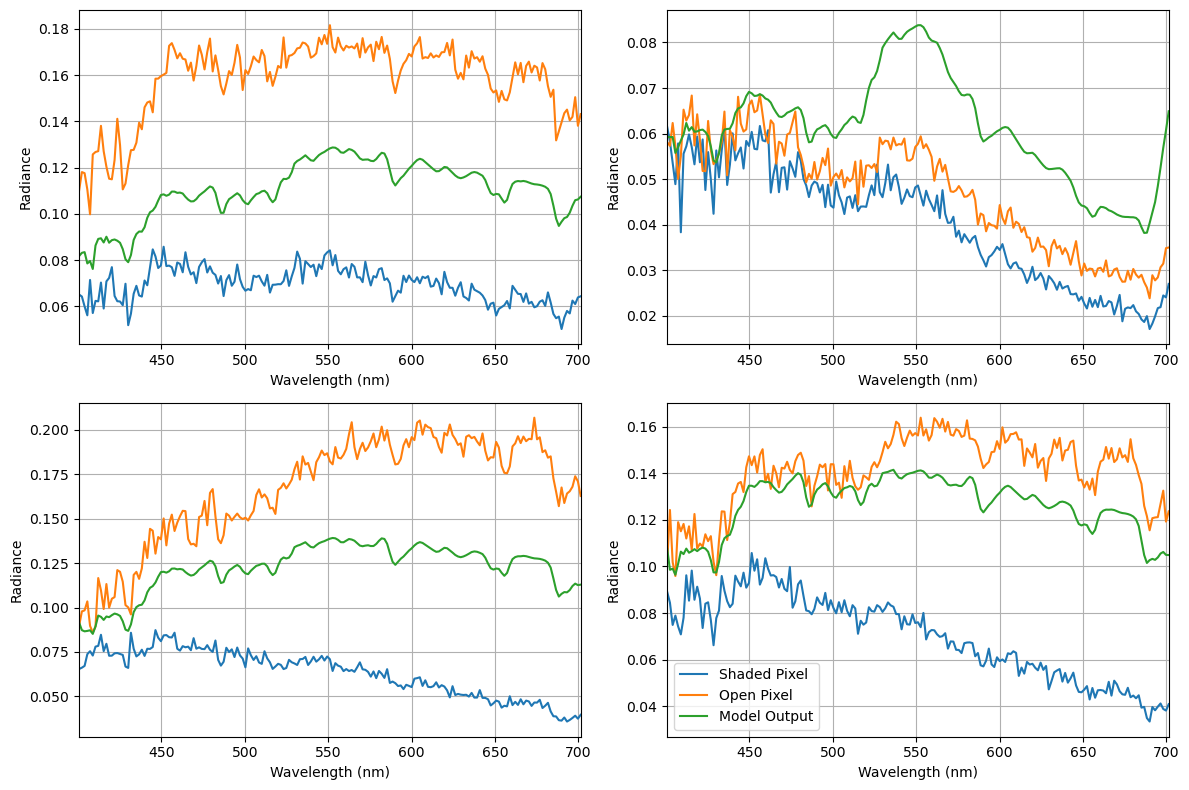

In [19]:
min_krr_model = KernelRidge(**best_model_params['min'])
min_krr_model.fit(reduced_observation_matrix, reduced_target_matrices['min'])

reduced_space_predictions = min_krr_model.predict(reduced_observation_matrix)
reconstructed_predictions = pc.reconstruct(reduced_space_predictions)

plt.figure(figsize=(12,8))
for plot in [ 221, 222, 223, 224 ]:
    
    sample_index = np.random.randint(0, len(observation_indices))
    spectra = [ 
        observation_matrix[sample_index, :], 
        target_matrices['min'][sample_index, :],
        reconstructed_predictions[sample_index, :] 
    ]

    plt.subplot(plot)
    if plot == 224:
        spectra_plot(wavelengths, np.array(spectra), legend_labels=['Shaded Pixel', 'Open Pixel', 'Model Output'])
    else : spectra_plot(wavelengths, np.array(spectra))

plt.tight_layout()
plt.show()

#### Model 02. Support Vector Regression ####

While the above approach works well for some of the correspondences, it is not very consistent. The regression model itself is a simple mapping which does not take any additional factors into account. We want our approach to make better use of the data sources available, and consider some of the relative differences in geometry and spectral content present within the correspondences used.  

Truly learning a mapping of the form $f:\mathbb{R}^p\rightarrow\mathbb{R}^p$ where $p$ is the dimensionality (number of bands) of the data is a remarkably challenging task. One solution, shown below, is to develop one model per speactral band. Though this approach is more computationally intensive, it does align more closely with our intuition about the process: we want to map radiance values for each wavelength in the shade to a reasonable estimate of what they would be in the open.

Our principal components from earlier will come into play in a different fashion for this approach. Instead of being used to simplify the data set, they will provide information about the spectra as a whole for each training observation. A projection of an observation onto a principal component is a linear combination of the entire spectra with the elements of the component. This means a single number (or more if selected) provides general information about the shape of the spectra as a whole.

Our input data matrix to the model will therefore have the columns outlined below; the target will be the per-band radiance value in the open pixel chosen from the correspondences.

| radiance | intensity | skyview factor | intensity | skyview factor |  *k*-pca scores | *k*-pca scores |
| - | - | - | - | - | - | - |
| (shade) | (shade) | (shade) | (open) | (open) | (shade) | (open) |

In [46]:
lidar_features = np.hstack((intensity.reshape(intensity.size, 1), skyview.reshape(skyview.size,1)))
lidar_features_shade = lidar_features[observation_indices, :]
lidar_features_open = lidar_features[min_target_indices, :]

pca_variance_explained_criteria = 0.999
sum_variance_explained = 0
pcs_used = 0
while sum_variance_explained < pca_variance_explained_criteria:
    sum_variance_explained += pc.variance_explained[pcs_used]
    pcs_used += 1

pca_features_shade = pc.reduce_dimension(observation_matrix, pcs_used)
pca_features_open = pc.reduce_dimension(target_matrices['min'], pcs_used)

# the only portion of our training matrix that changes for each model is the current band's radiance
# we can build the entirety of the matrix except for the first column prior to any looping

svm_observation_matrix = np.hstack((lidar_features_shade, lidar_features_open,
                                    pca_features_shade, pca_features_open))

# scale all values to [0,1]
svm_observation_matrix = (svm_observation_matrix - np.min(svm_observation_matrix, axis = 0)) / np.max(svm_observation_matrix, axis=0)

# insert column of zeros at beginnng as placeholder for each bands shadow radiance values
svm_observation_matrix = np.hstack((np.zeros((len(correspondences), 1), dtype=float), svm_observation_matrix))


In [48]:
from sklearn.svm import SVR

parameters = { 'C': [ 0.5, 0.75, 1.0, 1.25 ], 'gamma': [ 0.001, 0.005, 0.01, 0.05  ] }
model = GridSearchCV(SVR(), parameters, scoring='neg_mean_squared_error', cv=10)

best_model_params = {}
per_band_rmse = []

for i in range(len(wavelengths)):

    svm_observation_matrix[:,0] = observation_matrix[:,i]
    target = target_matrices['min'][:,i]
    model.fit(svm_observation_matrix, target)
    best_model_params[i] = model.best_params_
    per_band_rmse.append(-model.best_score_)

print('Average band-wise RMSE: {:.3f}'.format(np.mean(per_band_rmse)))

Average band-wise RMSE: 0.004


#### Support Vector Regression Output Plots ####

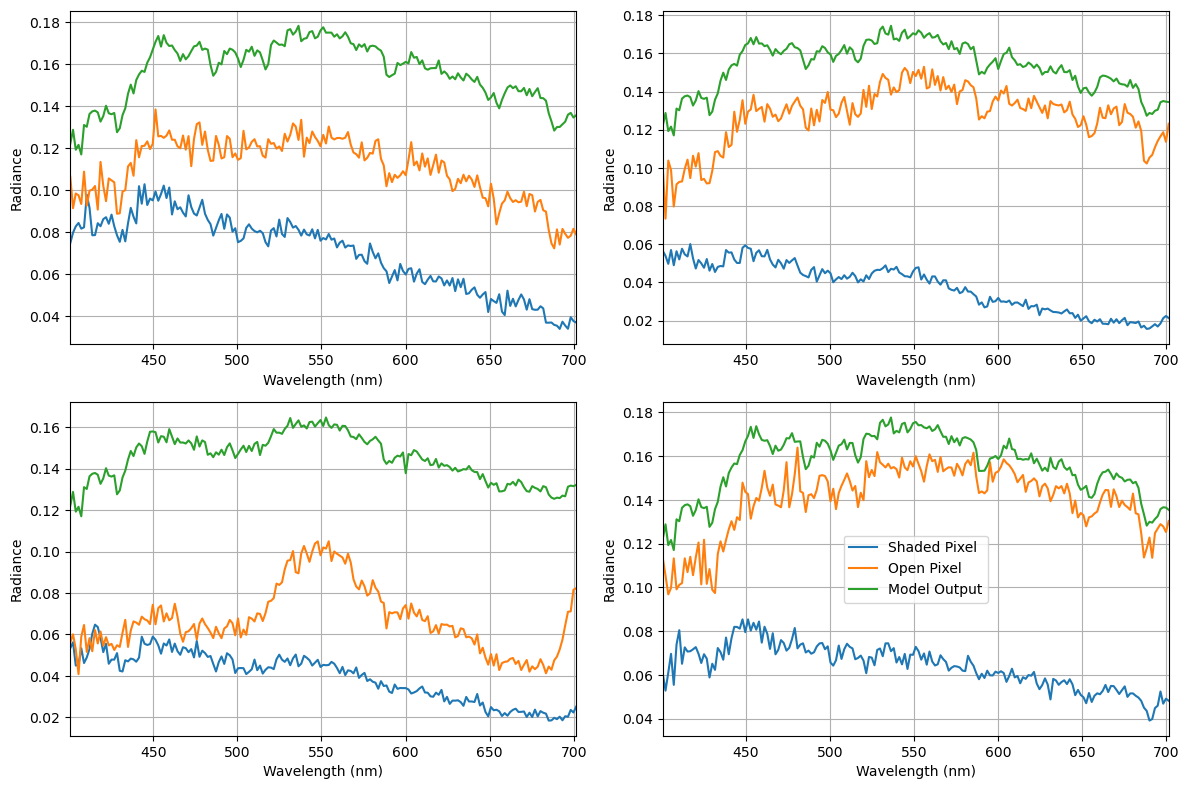

In [50]:

svr_estimates = np.zeros_like(observation_matrix)
for i in range(len(wavelengths)):
    
    svm_observation_matrix[:,0] = observation_matrix[:,i]
    target = target_matrices['min'][:,i]
    svr_model = SVR(**best_model_params[i])
    svr_model.fit(svm_observation_matrix, target)
    svr_estimates[:,i] = svr_model.predict(svm_observation_matrix)

plt.figure(figsize=(12,8))
for plot in [ 221, 222, 223, 224 ]:
    
    sample_index = np.random.randint(0, len(observation_indices))
    spectra = [ 
        observation_matrix[sample_index, :], 
        target_matrices['min'][sample_index, :],
        svr_estimates[sample_index, :] 
    ]

    plt.subplot(plot)
    if plot == 224:
        spectra_plot(wavelengths, np.array(spectra), legend_labels=['Shaded Pixel', 'Open Pixel', 'Model Output'])
    else : spectra_plot(wavelengths, np.array(spectra))

plt.tight_layout()
plt.show()